<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Santiago/1_Baseline_Notebook_Exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedPerf - Baseline notebook for experiments

## Setup & Dependencies Installation

In [1]:
!pip install torchsummaryX

In [2]:
%load_ext tensorboard

import copy
from functools import reduce
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import Sampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchsummaryX import summary as summaryx
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm

%matplotlib inline

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
RANDOM_SEED = 42

# general reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Wed Apr  7 22:47:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount GDrive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading Datasets

In [4]:
!rm -Rf data
!mkdir -p data scripts

### MNIST

In [5]:
transforms_mnist = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [6]:
# Commented as it throws a `HTTP Error 503: Service Unavailable` error
# mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
# mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

In [7]:
# Run this if the above cell is still throwing a 503 error
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz -O data/MNIST.tar.gz
!tar -zxvf ./data/MNIST.tar.gz -C data/

--2021-04-07 22:47:52--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-07 22:47:53--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘data/MNIST.tar.gz’

data/MNIST.tar.gz       [     <=>            ]  33.20M  5.02MB/s    in 18s     

2021-04-07 22:48:12 (1.80 MB/s) - ‘data/MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNI

In [8]:
# Run this if the above cell is still throwing a 503 error
mnist_data_train = datasets.MNIST(root='./data', train=True, download=False, transform=transforms_mnist)
mnist_data_test = datasets.MNIST(root='./data', train=False, download=False, transform=transforms_mnist)

In [9]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))

Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [10]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


In [11]:
# dl = DataLoader(mnist_data_train, batch_size=10)
# for t, l in dl:
#     print(t.shape, l.shape)
#     break

### CIFAR

In [12]:
# transforms_cifar10 = transforms.Compose([transforms.ToTensor(),
#                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                          ])

# cifar10_data_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
# cifar10_data_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)

In [13]:
# classes = np.array(list(cifar10_data_train.class_to_idx.values()))
# classes_test = np.array(list(cifar10_data_test.class_to_idx.values()))
# num_classes = len(classes_test)
# print("Classes: {} \tType: {}".format(classes, type(classes)))
# print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))

In [14]:
# print("Image Shape: {}".format(cifar10_data_train.data[0].shape))

### Shakespeare

In [58]:
GENERATE_DATASET = False  # If False, download the dataset provided by the q-FFL paper
DATA_DIR = 'data/'
# Dataset generation params
# SAMPLES_FRACTION = 0.2  # Fraction of total samples in the dataset
SAMPLES_FRACTION = 0.05  # Fraction of total samples in the dataset
TRAIN_FRACTION = 0.8  # Train set size
# MIN_SAMPLES = 0  # Min samples per client (for filtering purposes) - FedProx
MIN_SAMPLES = 64  # Min samples per client (for filtering purposes) - qFFL

In [16]:
# Download raw dataset
# !wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt -O data/shakespeare.txt
!wget --adjust-extension http://www.gutenberg.org/files/100/100-0.txt -O data/shakespeare.txt

--2021-04-07 22:48:13--  http://www.gutenberg.org/files/100/100-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5757108 (5.5M) [text/plain]
Saving to: ‘data/shakespeare.txt’

data/shakespeare.tx 100%[===================>]   5.49M  3.28MB/s    in 1.7s    

2021-04-07 22:48:16 (3.28 MB/s) - ‘data/shakespeare.txt’ saved [5757108/5757108]



In [17]:
if not GENERATE_DATASET:
    !rm -Rf data/train data/test
    !gdown --id 1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD  # Download Shakespeare dataset used by q-FFL paper
    !unzip shakespeare.zip
    !mv -f shakespeare_paper/train data/
    !mv -f shakespeare_paper/test data/
    !rm -R shakespeare_paper/ shakespeare.zip


Downloading...
From: https://drive.google.com/uc?id=1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD
To: /content/shakespeare.zip
2.96MB [00:00, 89.6MB/s]
Archive:  shakespeare.zip
   creating: shakespeare_paper/
   creating: shakespeare_paper/test/
  inflating: shakespeare_paper/test/all_data_niid_2_keep_0_test_8.json  
   creating: shakespeare_paper/train/
  inflating: shakespeare_paper/train/all_data_niid_2_keep_0_train_8.json  


#### Dataset Preprocessing script

In [18]:
corpus = []
with open('data/shakespeare.txt', 'r') as f:
    data = list(f.read())
    corpus = list(set(list(data)))
print('Corpus Length:', len(corpus))

Corpus Length: 108


In [19]:
%%capture
if GENERATE_DATASET:
    # Download dataset generation scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/preprocess_shakespeare.py -O scripts/preprocess_shakespeare.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/shake_utils.py -O scripts/shake_utils.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/gen_all_data.py -O scripts/gen_all_data.py

    # Download data preprocessing scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/sample.py -O scripts/sample.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/remove_users.py -O scripts/remove_users.py

In [20]:
# Running scripts
if GENERATE_DATASET:
    !mkdir -p data/raw_data data/all_data data/train data/test
    !python scripts/preprocess_shakespeare.py data/shakespeare.txt data/raw_data
    !python scripts/gen_all_data.py

##### Dataset split script

In [21]:
if GENERATE_DATASET:
    subdir = 'data/all_data'
    files = [f for f in os.listdir(subdir) if f.endswith('.json')]

    for f in files:
        print('Processing -> {}'.format(f))
        include_hierarchy = False
        file_dir = os.path.join(subdir, f)
        with open(file_dir, 'r') as file:
            data = json.load(file)

        users = data['users']
        num_users = len(users)
        tot_num_samples = sum(data['num_samples'])
        print('Fraction: ', SAMPLES_FRACTION)
        num_new_samples = int(SAMPLES_FRACTION * tot_num_samples)

        hierarchies = None

        ctot_num_samples = 0

        users_and_hiers = None
        if 'hierarchies' in data:
            include_hierarchy = True
            users_and_hiers = list(zip(users, data['hierarchies']))
            random.shuffle(users_and_hiers)
        else:
            random.shuffle(users)

        user_i = 0
        num_samples = []
        user_data = {}

        if include_hierarchy:
            hierarchies = []

        users_subset = [] # subsample users

        while ctot_num_samples < num_new_samples and user_i < num_users:
            hierarchy = None
            if users_and_hiers is not None:
                user, hier = users_and_hiers[user_i]
            else:
                user = users[user_i]

            cdata = data['user_data'][user]

            cnum_samples = len(data['user_data'][user]['y'])

            if cnum_samples > MIN_SAMPLES:

                if (ctot_num_samples + cnum_samples > num_new_samples):
                    cnum_samples = num_new_samples - ctot_num_samples
                    indices = list(range(cnum_samples))
                    new_indices = random.sample(indices, cnum_samples)
                    x, y = [], []
                    for i in new_indices:
                        x.append(data['user_data'][user]['x'][i])
                        y.append(data['user_data'][user]['y'][i])
                    cdata = {'x': x, 'y': y}
                
                if include_hierarchy:
                    hierarchies.append(hier)

                num_samples.append(cnum_samples)
                user_data[user] = cdata

                ctot_num_samples += cnum_samples

                users_subset.append(user)

            user_i += 1

        # ------------
        # create .json file

        all_data = {}
        all_data['users'] = users_subset
        if include_hierarchy:
            all_data['hierarchies'] = hierarchies
        all_data['num_samples'] = num_samples
        all_data['user_data'] = user_data

        #########################################

        # Split data for train/test
        num_samples_train, num_samples_test = [], []
        user_data_train, user_data_test = {}, {}

        user_indices = [] # indices of users in all_data['users'] that are not deleted

        for i, u in enumerate(all_data['users']):
            user_data_train[u] = {'x': [], 'y': []}
            user_data_test[u] = {'x': [], 'y': []}

            curr_num_samples = len(all_data['user_data'][u]['y'])
            if curr_num_samples >= 2:
                user_indices.append(i)
                # ensures number of train and test samples both >= 1
                num_train_samples = max(1, int(TRAIN_FRACTION * curr_num_samples))
                if curr_num_samples == 2:
                    num_train_samples = 1

                num_test_samples = curr_num_samples - num_train_samples
                num_samples_train.append(num_train_samples)
                num_samples_test.append(num_test_samples)

                indices = list(range(curr_num_samples))
                train_indices = random.sample(indices, num_train_samples)
                train_blist = [False for _ in range(curr_num_samples)]
                for j in train_indices:
                    train_blist[j] = True

                for j in range(curr_num_samples):
                    if (train_blist[j]):
                        user_data_train[u]['x'].append(all_data['user_data'][u]['x'][j])
                        user_data_train[u]['y'].append(all_data['user_data'][u]['y'][j])
                    else:
                        user_data_test[u]['x'].append(all_data['user_data'][u]['x'][j])
                        user_data_test[u]['y'].append(all_data['user_data'][u]['y'][j])

        users = [all_data['users'][i] for i in user_indices]

        all_data_train = {}
        all_data_train['users'] = users
        all_data_train['num_samples'] = num_samples_train
        all_data_train['user_data'] = user_data_train
        all_data_test = {}
        all_data_test['users'] = users
        all_data_test['num_samples'] = num_samples_test
        all_data_test['user_data'] = user_data_test

        if include_hierarchy:
            all_data_train['hierarchies'] = all_data['hierarchies']
            all_data_test['hierarchies'] = all_data['hierarchies']

        slabel = 'niid'
        arg_frac = str(SAMPLES_FRACTION)[2:]
        arg_label = f'{slabel}_{arg_frac}_keep_{MIN_SAMPLES}'

        file_name_train = '%s_niid_%s_train_%s.json' % ((f[:-5]), arg_label, str(TRAIN_FRACTION)[2:])
        file_name_test = '%s_niid_%s_test_%s.json' % ((f[:-5]), arg_label, str(round(1. - TRAIN_FRACTION, 1))[2:])
        ouf_dir_train = os.path.join(DATA_DIR, 'train', file_name_train)
        ouf_dir_test = os.path.join(DATA_DIR, 'test', file_name_test)
        print('writing %s' % file_name_train)
        with open(ouf_dir_train, 'w') as outfile:
            json.dump(all_data_train, outfile)
        print('writing %s' % file_name_test)
        with open(ouf_dir_test, 'w') as outfile:
            json.dump(all_data_test, outfile)


#### Dataset class

##### Centralized dataset

In [22]:
class RandomSequentialSampler(Sampler):
    def __init__(self, datasource, seq_count):
        self.source = datasource
        self.seq_count = seq_count

    def __iter__(self):
        flatten = lambda l: [item for sublist in l for item in sublist]
        # groups = [[range(i, i + self.seq_count)] for i in range(0, len(self), self.seq_count)]
        groups = [[(i, i + self.seq_count)] for i in range(0, len(self), self.seq_count)]
        # print('groups', groups)
        random.shuffle(groups)
        # groups = flatten(flatten(groups))
        groups = flatten(groups)
        # print('groups final', len(groups))
        return iter(groups)

    def __len__(self):
        return len(self.source) - self.seq_count


class ShakespeareDataset(Dataset):
    def __init__(self, fname='./data/shakespeare.txt'):
        super(ShakespeareDataset, self).__init__()

        self.data = ''
        self.corpus = []
        with open(fname, 'r') as f:
            self.data = list(f.read())
            self.corpus = list(set(list(self.data)))

    def __len__(self):
        return len(self.data) - 1

    def __repr__(self):
        return f'{self.__class__} - (length: {self.__len__()})'

    def __getitem__(self, i):
        # print('getitem', i)
        # start, end = self.data[i], self.data[i+1]
        # input_value = torch.zeros(1, len(self.corpus))
        input_seq = self.data[slice(*i)]
        next_char = self.data[i[1] + 1]
        # print('input_seq', len(input_seq))
        # input_value[0] = ShakespeareDataset.one_hot(self.get_label_from_char(start), len(self.corpus))
        corpus_size = len(self.corpus)
        input_value = torch.stack([ShakespeareDataset.one_hot(self.get_label_from_char(w), corpus_size) for w in input_seq])
        # print('input value', input_value.shape)
        # target_value = torch.Tensor([[self.get_label_from_char(end)]])
        target_value = torch.Tensor([[self.get_label_from_char(next_char)]])
        return [ input_value, target_value ]

    @staticmethod
    def one_hot(l, classes):
        x = torch.zeros(classes)
        x[l] = 1
        return x

    def sequential_sampler(self, seq_count, batch_size):
        return DataLoader(self,
                          sampler=RandomSequentialSampler(self, seq_count),
                          batch_size=batch_size,
                          pin_memory=torch.cuda.is_available(),
                          num_workers=4)

    def get_label_from_char(self, c):
        return self.corpus.index(c)

    def get_char_from_label(self, l):
        return self.corpus[l]

In [23]:
# # Test
# shakespeare_ds = ShakespeareDataset()
# print(len(shakespeare_ds.corpus), len(shakespeare_ds))

# dl = shakespeare_ds.sequential_sampler(80, 15)
# print(len(dl))

# for s in dl:
#     print(len(s))
#     print(s[0].shape, s[1].shape)
#     break

##### Federated Dataset

In [24]:
# CHAR_CORPORA = "\n !\"&'(),-.0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz}"
# ",".join([c for c in corpus if c not in CHAR_CORPORA])

In [25]:
class ShakespeareFedDataset(Dataset):
    def __init__(self, x, y, corpus, seq_length):
        super(ShakespeareFedDataset, self).__init__()

        self.x = x
        self.y = y
        self.corpus = corpus
        self.corpus_size = len(self.corpus)

    def __len__(self):
        return len(self.x)

    def __repr__(self):
        return f'{self.__class__} - (length: {self.__len__()})'

    def __getitem__(self, i):
        input_seq = self.x[i]
        next_char = self.y[i]
        input_value = torch.stack([ShakespeareFedDataset.one_hot(self.get_label_from_char(w), self.corpus_size) for w in input_seq])
        # target_value = torch.LongTensor([self.get_label_from_char(next_char)])
        target_value = torch.as_tensor(self.get_label_from_char(next_char), dtype=torch.long)
        return [ input_value, target_value ]

    @staticmethod
    def one_hot(l, classes):
        x = torch.zeros(classes, dtype=torch.int32)
        x[l] = 1
        return x

    def dataloader(self, batch_size, shuffle=True):
        return DataLoader(self,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          num_workers=0)

    def get_label_from_char(self, c):
        return self.corpus.index(c)

    def get_char_from_label(self, l):
        return self.corpus[l]

In [26]:
# # TEST
# train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
# with open(train_file, 'r') as file:
#     data_train = json.load(file)
# x = data_train['user_data'][data_train['users'][0]]['x']
# y = data_train['user_data'][data_train['users'][0]]['y']
# shakespeare_ds = ShakespeareFedDataset(x, y, corpus=corpus)
# print(len(shakespeare_ds))

# dl = shakespeare_ds.dataloader(15)
# print(len(dl))

# for s in dl:
#     print(len(s))
#     print(s[0].shape, s[1].shape)
#     break

In [27]:
# def get_label_from_char(corpus, c):
#     return corpus.index(c)

# def one_hot_tensor(l, classes):
#     x = torch.zeros(classes, dtype=torch.int32)
#     x[l] = 1
#     return x

# def preprocess(x, y, corpus):

#     corpus_size = len(corpus)
#     x = [[one_hot_tensor(get_label_from_char(corpus, w), corpus_size) for w in input_seq] for input_seq in x]
#     y = [get_label_from_char(corpus, next_char) for next_char in y]

#     return x, y


# class ShakespeareFedDataset(Dataset):
#     def __init__(self, x, y, corpus, seq_length):
#         super(ShakespeareFedDataset, self).__init__()

#         self.x = x
#         self.y = y

#     def __len__(self):
#         return len(self.x)

#     def __repr__(self):
#         return f'{self.__class__} - (length: {self.__len__()})'

#     def __getitem__(self, i):
#         input_seq = self.x[i]
#         next_char = self.y[i]
#         input_value = torch.stack(input_seq)
#         target_value = torch.as_tensor(next_char, dtype=torch.long)
#         return [ input_value, target_value ]

#     def dataloader(self, batch_size, shuffle=True):
#         return DataLoader(self,
#                           batch_size=batch_size,
#                           shuffle=shuffle,
#                           num_workers=0)

In [28]:
# # TEST
# train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
# with open(train_file, 'r') as file:
#     data_train = json.load(file)
# x = data_train['user_data'][data_train['users'][0]]['x']
# y = data_train['user_data'][data_train['users'][0]]['y']
# x, y = preprocess(x, y, corpus)
# shakespeare_ds = ShakespeareFedDataset(x, y)
# print(len(shakespeare_ds))

# dl = shakespeare_ds.dataloader(15)
# print(len(dl))

# for s in dl:
#     print(len(s))
#     print(s[0].shape, s[1].shape)
#     break

## Partitioning & Data Loaders

### IID

In [29]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

### Non-IID

#### MNIST

In [30]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

#### Shakespeare

In [59]:
def shakespeare_noniid_partition(corpus, seq_length=80, val_split=True):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.load(file)

    with open(test_file, 'r') as file:
        data_test = json.load(file)

    data_dict = {}

    x_test, y_test = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)

    # total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    # print('Objective', total_samples, '/', sum(data_train['num_samples']))
    # sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        # if sample_count >= total_samples:
        #     print('Max samples reached', sample_count, '/', total_samples)
        #     break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            # max_samples = samples if (sample_count + samples) < total_samples else (sample_count + samples - total_samples) 
            max_samples = int(samples * SAMPLES_FRACTION)
            
            # sample_count += max_samples
            # print('sample_count', sample_count)

            x_train = data_train['user_data'][author_id]['x'][:max_samples]
            y_train = data_train['user_data'][author_id]['y'][:max_samples]
            train_ds = ShakespeareFedDataset(x_train, y_train, corpus, seq_length)

            x_val, y_val = None, None
            val_ds = None
            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)
            if val_split:
                x_test += author_data['x'][:int(test_size / 2)]
                y_test += author_data['y'][:int(test_size / 2)]
                x_val = author_data['x'][int(test_size / 2):]
                y_val = author_data['y'][int(test_size / 2):int(test_size)]

                val_ds = ShakespeareFedDataset(x_val, y_val, corpus, seq_length)
            else:
                x_test += author_data['x'][:int(test_size)]
                y_test += author_data['y'][:int(test_size)]

            data_dict[author_id] = {
                'train_ds': train_ds,
                'val_ds': val_ds
            }

    test_ds = ShakespeareFedDataset(x_test, y_test, corpus, seq_length)

    return data_dict, test_ds

In [32]:
# def shakespeare_noniid_partition(corpus, seq_length=80, val_split=True):

#     train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
#     test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

#     with open(train_file, 'r') as file:
#         data_train = json.load(file)

#     with open(test_file, 'r') as file:
#         data_test = json.load(file)

#     data_dict = {}

#     x_test, y_test = [], []
    
#     for i, author_id in enumerate(data_train['users']):

#         if data_train['num_samples'][i] < 64 or data_train['num_samples'][i] > 10000:
#             print('SKIP', author_id, data_train['num_samples'][i])
#             continue
#         else:
#             x_train = data_train['user_data'][author_id]['x']
#             y_train = data_train['user_data'][author_id]['y']
#             x_train, y_train = preprocess(x_train, y_train, corpus)
#             train_ds = ShakespeareFedDataset(x_train, y_train, corpus, seq_length)

#             x_val, y_val = None, None
#             val_ds = None
#             if val_split:
#                 author_data = data_test['user_data'][author_id]
#                 test_size = len(author_data['x'])
#                 x_test += author_data['x'][:int(test_size / 2)]
#                 y_test += author_data['y'][:int(test_size / 2)]
#                 x_val = author_data['x'][int(test_size / 2):]
#                 y_val = author_data['y'][int(test_size / 2):]

#                 x_val, y_val = preprocess(x_val, y_val, corpus)
#                 val_ds = ShakespeareFedDataset(x_val, y_val, corpus, seq_length)
#             else:
#                 x_test += data_test['user_data'][author_id]['x']
#                 y_test += data_test['user_data'][author_id]['y']

#             data_dict[author_id] = {
#                 'train_ds': train_ds,
#                 'val_ds': val_ds
#             }

#     x_test, y_test = preprocess(x_test, y_test, corpus)
#     test_ds = ShakespeareFedDataset(x_test, y_test, corpus, corpus, seq_length)

#     return data_dict, test_ds

## Models

### MNIST CNN

In [33]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

#### Model Summary

In [34]:
# mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
#   mnist_mlp.cuda()
  mnist_cnn.cuda()

# print("MNIST MLP SUMMARY")
# print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))


MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264
         MaxPool2d-4             [-1, 64, 4, 4]               0
           Dropout-5             [-1, 64, 4, 4]               0
            Linear-6                  [-1, 512]         524,800
            Linear-7                   [-1, 10]           5,130
Total params: 582,026
Trainable params: 582,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 2.22
Estimated Total Size (MB): 2.45
----------------------------------------------------------------
None


### Shakespeare LSTM

In [35]:
class ShakespeareLSTM(nn.Module):
    """
    """

    def __init__(self, input_dim, embedding_dim, hidden_dim, classes, lstm_layers=2, dropout=0.1, batch_first=True):
        super(ShakespeareLSTM, self).__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.classes = classes
        self.no_layers = lstm_layers
        
        self.embedding = nn.Embedding(num_embeddings=classes,
                                      embedding_dim=self.embedding_dim)
        # self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=0.2)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, 
                            hidden_size=self.hidden_dim,
                            num_layers=self.no_layers,
                            batch_first=batch_first, 
                            dropout=dropout if self.no_layers > 1 else 0.)
        self.fc = nn.Linear(hidden_dim, self.classes)
        # self.dropout = nn.Dropout(dropout)
        # self.activation = nn.Sigmoid()
        # self.activation = nn.Softmax(dim=1)

    def forward(self, x, hc=None):
        batch_size = x.size()[0]
        # print('x', x.size())
        xb = x.view(-1, self.classes)
        # print('xb', xb.size())
        x_emb = self.embedding(xb)
        # print('x_emb', x_emb.size())
        out, (ht, ct) = self.lstm(x_emb)
        # print('ht', ht.size())
        dense = self.fc(ht[-1])
        # print('dense', dense.size())
        dense = dense.view(-1, batch_size, self.classes)[-1]  # TODO: is this correct? [-1] for the sequence next character only
        # print('dense', dense.size())
        # out = self.activation(dense)
        out = F.log_softmax(dense, dim=1)
        # out = out.view(-1, batch_size, self.classes)
        # print('out', out.size())
        return out
        # return out.view(-1, self.classes)

#### Model Summary

In [36]:
shakespeare_lstm = ShakespeareLSTM(input_dim=80,  # mcmahan17a, fedprox, qFFL
                                   embedding_dim=8,  # mcmahan17a, fedprox, qFFL
                                   # hidden_dim=256,  # mcmahan17a
                                   hidden_dim=100,  # fedprox
                                   classes=len(corpus),
                                   lstm_layers=2,
                                   dropout=0.1,  # TODO:
                                   batch_first=True
                                   )

if torch.cuda.is_available():
  shakespeare_lstm.cuda()

# print("MNIST MLP SUMMARY")
# print(summary(mnist_mlp, (28,28)))

x_sample = torch.zeros((10, 80, len(corpus)),
                       dtype=torch.long,
                       device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')))
x_sample[0][0][0] = 1
x_sample

print("\nShakespeare LSTM SUMMARY")
# print(summary(shakespeare_lstm, (1, 80, len(corpus))))
print(summaryx(shakespeare_lstm, x_sample))


Shakespeare LSTM SUMMARY
            Kernel Shape     Output Shape  Params  Mult-Adds
Layer                                                       
0_embedding     [8, 108]    [800, 108, 8]     864        864
1_lstm                 -  [800, 108, 100]  124800     123200
2_fc          [100, 108]       [800, 108]   10908      10800
------------------------------------------------------------
                      Totals
Total params          136572
Trainable params      136572
Non-trainable params       0
Mult-Adds             134864
            Kernel Shape     Output Shape  Params  Mult-Adds
Layer                                                       
0_embedding     [8, 108]    [800, 108, 8]     864        864
1_lstm                 -  [800, 108, 100]  124800     123200
2_fc          [100, 108]       [800, 108]   10908      10800


## Algorithms

### Utils

In [37]:
from sklearn.metrics import f1_score

In [38]:
def plot_scores(history, file='test_scores.jpg'):
    accuracies = [x['accuracy'] for x in history]
    f1_macro = [x['f1_macro'] for x in history]
    f1_weighted = [x['f1_weighted'] for x in history]

    fig, ax = plt.subplots()

    ax.plot(accuracies, '-x', label='Valid Acc')
    ax.plot(f1_macro, '-x', label='F1 (macro)')
    ax.plot(f1_weighted, '-x', label='F1 (weighted)')
    ax.set(xlabel='epoch', ylabel='score', title='Score vs. No. of epochs')
    ax.legend();

    fig.savefig(file, format='jpg')


def plot_losses(history, file='test_loss.jpg'):
    val_losses = [x['loss'] for x in history]

    fig, ax = plt.subplots()

    ax.plot(val_losses, '-rx')
    ax.set(xlabel='epoch', ylabel='loss', title='Loss vs. No. of epochs')
    ax.legend(['Validation'])

    fig.savefig(file, format='jpg')


### FedAvg

In [39]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

In [40]:
# TODO

### FedProx

In [41]:
# TODO

### qFedAvg

#### Local Training (Client update)

In [42]:
class ClientUpdate(object):
  def __init__(self, dataset, batch_size, learning_rate, epochs, idxs, q=None):
    """

    """
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs
    self.q = q
    if not self.q:
        # TODO: Client itself adjust fairness 
        pass
    self.mu = 1e-10

  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    model_weights = copy.deepcopy(model.state_dict())
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      # for data, labels in tqdm(self.train_loader):
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        # print('input', data.size())
        output = model(data)
        # print('output', output.size())
        # print('labels', labels.size())
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)


    total_loss = sum(e_loss)/len(e_loss)

    # delta weights
    model_weights_new = copy.deepcopy(model.state_dict())
    L = 1.0 / self.learning_rate

    # delta_weights = torch.tensor([(u - v) * L for u, v in zip(model_weights, model_weights_new)],
    #                              device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')))
    # # delta = [np.float_power(total_loss + self.mu, self.q) * grad for grad in delta_weights]
    # delta = delta_weights * np.float_power(total_loss + self.mu, self.q)
    # # Estimation of the local Lipchitz constant
    # h = (self.q * np.float_power(total_loss + self.mu, self.q - 1) * torch.pow(torch.norm(delta_weights), 2)) + \
    #     (L * np.float_power(total_loss + self.mu, self.q))

    delta_weights, delta, h = {}, {}, {}
    loss_q = np.float_power(total_loss + self.mu, self.q)
    # updating the global weights
    for k in model_weights_new.keys():
      delta_weights[k] = (model_weights[k] - model_weights_new[k]) * L
      delta[k] =  loss_q * delta_weights[k]
      # Estimation of the local Lipchitz constant
      h[k] = (self.q * np.float_power(total_loss + self.mu, self.q - 1) * torch.pow(torch.norm(delta_weights[k]), 2)) + (L * loss_q)

    return delta, h, total_loss

#### Server Side Training

In [43]:
def client_sampling(n, m, weights=None, with_replace=False):
    pk = None
    if weights:
        total_weights = np.sum(np.asarray(weights))
        pk = [w * 1.0 / total_weights for w in weights]

    return np.random.choice(range(n), m, replace=with_replace, p=pk)

In [44]:
def training(model, rounds, batch_size, lr, ds, data_dict, test_ds, C, K, E, q=0, sampling='uniform', tb_logger=None, test_history=[], perf_fig_file='loss.jpg'):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - test_ds          Dataset used for global testing
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - q:               Parameter that tunes the amount of fairness we wish to impose (default: 0 -> vanilla FedAvg objective)
    - sampling         Uniform or weighted (default: uniform)
    - tb_logger:       Tensorboard SummaryWriter
    - test_history:    Test Scores history log
    - perf_fig_file    File for storing final performance plot (loss)
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # client weights by total samples
  p_k = None
  if sampling == 'weighted':
    p_k = [len(data_dict[c]) for c in data_dict] if ds else [len(data_dict[c]['train_ds']) for c in data_dict]

  # Time log
  start_time = time.time()

  users_id = list(data_dict.keys())

  # Orchestrate training
  for curr_round in range(1, rounds+1):
    deltas, hs, local_loss = [], [], []

    m = max(int(C*K), 1)    
    S_t = client_sampling(K, m, weights=p_k, with_replace=False)

    print('Round: {} Picking {}/{} clients: {}'.format(curr_round, m, K, S_t))

    global_weights = model.state_dict()

    for k in tqdm(S_t):
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
      local_update = ClientUpdate(dataset=ds_, batch_size=batch_size, learning_rate=lr, epochs=E, idxs=idxs, q=q)
    #   weights, loss = local_update.train(model=copy.deepcopy(model))
      delta_k, h_k, loss = local_update.train(model=copy.deepcopy(model))

      deltas.append(copy.deepcopy(delta_k))
      hs.append(copy.deepcopy(h_k))
      local_loss.append(copy.deepcopy(loss))

      if tb_logger:
        tb_logger.add_scalar(f'Round/S{k}', loss, curr_round)

    # Perform qFedAvg
    h_sum = copy.deepcopy(hs[0])
    delta_sum = copy.deepcopy(deltas[0])
    
    for k in h_sum.keys():
        for i in range(1, len(hs)):
            h_sum[k] += hs[i][k]
            delta_sum[k] += deltas[i][k]

    new_weights = {}
    for k in delta_sum.keys():
        for i in range(len(deltas)):
            new_weights[k] = delta_sum[k] / h_sum[k]

    # Updating global model weights
    for k in global_weights.keys():
        global_weights[k] -= new_weights[k]

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    if tb_logger:
        tb_logger.add_scalar('Train/Loss', loss_avg, curr_round)
        # tb_logger.add_scalar(f'Train/Datapoints', total_datapoints, curr_round)
    
    if curr_round % 5 == 0:
        test_scores = testing(model, test_ds, batch_size, nn.CrossEntropyLoss(), num_classes, list(range(num_classes)))
        # test_scores = testing(model, test_ds, val_batch_size, nn.CrossEntropyLoss(weight=avg_weights), num_classes, list(range(num_classes)))
        test_history.append(test_scores)
        if tb_logger:
            tb_logger.add_scalar(f'Test/Loss', test_scores['loss'], curr_round)
            tb_logger.add_scalars(f'Test/Scores', {
                'accuracy': test_scores['accuracy'], 'f1_macro': test_scores['f1_macro'], 'f1_weighted': test_scores['f1_weighted']
            }, curr_round)
  
  end_time = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:orange')

  ax.set(xlabel='# Rounds', ylabel='Train Loss',
       title="Model's Performance with q: {}".format(q))
  ax.grid()
  fig.savefig(perf_fig_file, format='jpg')
  print("Training Done! Total time: {}".format(round(end_time - start_time, 3)))
  return model, test_history

#### Testing Loop

In [73]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  y_true, y_hat = None, None

  correct_class = list(0 for i in range(num_classes))
  total_class = list(0 for i in range(num_classes))

  if hasattr(dataset, 'dataloader'):
    test_loader = dataset.dataloader(batch_size=bs, shuffle=False)
  else:
    test_loader = DataLoader(dataset, batch_size=bs, shuffle=False)

  l = len(test_loader)

  model.eval()
  for i, (data, labels) in enumerate(tqdm(test_loader)):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, dim=1)

    # For F1Score
    y_true = np.append(y_true, labels.data.view_as(pred).cpu().numpy()) if i != 0 else labels.data.view_as(pred).cpu().numpy()
    y_hat = np.append(y_hat, pred.cpu().numpy()) if i != 0 else pred.cpu().numpy()

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    # for i in range(num_classes):
    #   label = labels.data[i]
    #   correct_class[label] += correct[i].item()
    #   total_class[label] += 1

    for i, lbl in enumerate(labels.data):
      try:
        # print(type(lbl))
        # correct_class[lbl.data[0]] += correct.data[i]
        correct_class[lbl.item()] += correct[i]
        total_class[lbl.item()] += 1
      except:
          print('Error', lbl, i)
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # Avg F1 Score
  f1_macro = f1_score(y_true, y_hat, average='macro')
  # F1-Score -> weigthed to consider class imbalance
  f1_weighted =  f1_score(y_true, y_hat, average='weighted')
  print("F1 Score: {:.6f} (macro) {:.6f} (weighted) %\n".format(f1_macro, f1_weighted))

  # print test accuracy
  for i in range(num_classes):
    if total_class[i] > 0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  overall_accuracy = np.sum(correct_class) / np.sum(total_class)
  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(overall_accuracy, np.sum(correct_class), np.sum(total_class)))

  return {'loss': test_loss, 'accuracy': overall_accuracy, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted}

## Experiments

In [47]:
BREAK-ON-PURPOSE

NameError: ignored

### IID

### Non-IID

#### FedAvg

In [ ]:
# TODO

#### FedProx

In [ ]:
# TODO

#### qFedAvg

##### MNIST

In [48]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10  # FedProx
# learning Rate
# lr = 0.01
lr = 0.03  # FedProx
# fairness
q = 0.001
# sampling
# sampling = 'uniform'
sampling = 'weighted'

In [49]:
# dict containing different type of data partition
data_dict = non_iid_partition(dataset=mnist_data_train,
                              clients=K,
                              total_shards=200,
                              shards_size=300,
                              num_shards_per_client=2)

In [50]:
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

In [51]:
BASE_DIR = '/content/gdrive/MyDrive/FedPerf/mnist'
exp_name = f'model_r{rounds}_c{C}_r{E}_q{q}_{sampling}'
log_dir = f'{BASE_DIR}/{exp_name}'
tb_logger = SummaryWriter(log_dir)
print(f'TBoard logger created at: {log_dir}')
exp_name

test_history = []

TBoard logger created at: /content/gdrive/MyDrive/FedPerf/mnist/model_r100_c0.1_r5_q0.001_weighted


Round: 1 Picking 10/100 clients: [77 21 50 23 40 78 22 92 59 37]



Round: 1... 	Average Loss: 0.105
Round: 2 Picking 10/100 clients: [50 60 55 48 17 81 54 13 76 93]



Round: 2... 	Average Loss: 0.045
Round: 3 Picking 10/100 clients: [94 36 13 51 11 93 18 25 40 38]



Round: 3... 	Average Loss: 0.046
Round: 4 Picking 10/100 clients: [79 45 17 26 50 14 61 56 71 93]



Round: 4... 	Average Loss: 0.03
Round: 5 Picking 10/100 clients: [91 94 24 13 30 89 97 85 11 42]



Round: 5... 	Average Loss: 0.032



Test Loss: 0.868849

F1 Score: 0.770374 (macro) 0.769913 (weighted) %

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1129/1135)
Test Accuracy of     2: 55% (570/1032)
Test Accuracy of     3: 87% (883/1010)
Test Accuracy of     4: 98% (967/982)
Test Accuracy of     5: 95% (856/892)
Test Accuracy of     6: 85% (816/958)
Test Accuracy of     7: 96% (990/1028)
Test Accuracy of     8: 56% (553/974)
Test Accuracy of     9: 20% (203/1009)

Final Test  Accuracy: 79.370 (7937/10000)
Round: 6 Picking 10/100 clients: [ 0 44  4 54 33 47 61 86 66 43]



Round: 6... 	Average Loss: 0.013
Round: 7 Picking 10/100 clients: [81 90 11 53 28  4 66 86 16 84]



Round: 7... 	Average Loss: 0.019
Round: 8 Picking 10/100 clients: [91 26 90 32 55  5  4 72 44 25]



Round: 8... 	Average Loss: 0.017
Round: 9 Picking 10/100 clients: [19 66  0 80  7 38 48 35 32 96]



Round: 9... 	Average Loss: 0.012
Round: 10 Picking 10/100 clients: [64  2 43 87 30  9 75 60 57  5]



Round: 10... 	Average Loss: 0.014



Test Loss: 0.461359

F1 Score: 0.853274 (macro) 0.854045 (weighted) %

Test Accuracy of     0: 97% (954/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 81% (836/1032)
Test Accuracy of     3: 90% (913/1010)
Test Accuracy of     4: 97% (953/982)
Test Accuracy of     5: 96% (857/892)
Test Accuracy of     6: 96% (927/958)
Test Accuracy of     7: 97% (999/1028)
Test Accuracy of     8: 42% (412/974)
Test Accuracy of     9: 65% (659/1009)

Final Test  Accuracy: 86.400 (8640/10000)
Round: 11 Picking 10/100 clients: [14 62 20 50 54 28 94 84 72  7]



Round: 11... 	Average Loss: 0.013
Round: 12 Picking 10/100 clients: [10 49 16 97 15 48 36 63 12 43]



Round: 12... 	Average Loss: 0.026
Round: 13 Picking 10/100 clients: [27 88  4 91 83 29 78  3 96 52]



Round: 13... 	Average Loss: 0.017
Round: 14 Picking 10/100 clients: [30 36  6 98  3 65 44 94 24 53]



Round: 14... 	Average Loss: 0.015
Round: 15 Picking 10/100 clients: [48 70  6 19 21 73 18 57 86 94]



Round: 15... 	Average Loss: 0.013



Test Loss: 0.306654

F1 Score: 0.883939 (macro) 0.884292 (weighted) %

Test Accuracy of     0: 97% (960/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 91% (941/1032)
Test Accuracy of     3: 93% (949/1010)
Test Accuracy of     4: 98% (969/982)
Test Accuracy of     5: 96% (864/892)
Test Accuracy of     6: 97% (930/958)
Test Accuracy of     7: 97% (998/1028)
Test Accuracy of     8: 82% (804/974)
Test Accuracy of     9: 38% (384/1009)

Final Test  Accuracy: 89.240 (8924/10000)
Round: 16 Picking 10/100 clients: [51 35 23  4 26 65 53 94 39 69]



Round: 16... 	Average Loss: 0.018
Round: 17 Picking 10/100 clients: [48 51 26 45 47 70 94 32  4 49]



Round: 17... 	Average Loss: 0.014
Round: 18 Picking 10/100 clients: [54 16 76 98 94 19 87 70 45 83]



Round: 18... 	Average Loss: 0.012
Round: 19 Picking 10/100 clients: [48 37 49 57 18 90 67 63  9 60]



Round: 19... 	Average Loss: 0.013
Round: 20 Picking 10/100 clients: [12  7 52 40 58  8 43 17 98 56]



Round: 20... 	Average Loss: 0.018



Test Loss: 0.197113

F1 Score: 0.943520 (macro) 0.943911 (weighted) %

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 93% (969/1032)
Test Accuracy of     3: 98% (993/1010)
Test Accuracy of     4: 82% (809/982)
Test Accuracy of     5: 94% (839/892)
Test Accuracy of     6: 95% (917/958)
Test Accuracy of     7: 96% (993/1028)
Test Accuracy of     8: 91% (890/974)
Test Accuracy of     9: 92% (933/1009)

Final Test  Accuracy: 94.400 (9440/10000)
Round: 21 Picking 10/100 clients: [68 32  9 97 28 42 64  2 81 53]



Round: 21... 	Average Loss: 0.007
Round: 22 Picking 10/100 clients: [27  6 16 89 68 24 69 57 40 37]



Round: 22... 	Average Loss: 0.013
Round: 23 Picking 10/100 clients: [21 66 97 17 59 42 44 25 82 48]



Round: 23... 	Average Loss: 0.017
Round: 24 Picking 10/100 clients: [54 30 18  8 71 19 69 39 41 46]



Round: 24... 	Average Loss: 0.015
Round: 25 Picking 10/100 clients: [36 10 30 66 28 46 19 21  2 90]



Round: 25... 	Average Loss: 0.015



Test Loss: 0.215744

F1 Score: 0.926247 (macro) 0.927906 (weighted) %

Test Accuracy of     0: 98% (967/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 94% (980/1032)
Test Accuracy of     3: 90% (916/1010)
Test Accuracy of     4: 83% (820/982)
Test Accuracy of     5: 99% (890/892)
Test Accuracy of     6: 93% (900/958)
Test Accuracy of     7: 94% (973/1028)
Test Accuracy of     8: 75% (737/974)
Test Accuracy of     9: 95% (961/1009)

Final Test  Accuracy: 92.740 (9274/10000)
Round: 26 Picking 10/100 clients: [21 22 27 12 63  7 13 64 33 70]



Round: 26... 	Average Loss: 0.01
Round: 27 Picking 10/100 clients: [55 25 65 11 53 43 26 60 87 99]



Round: 27... 	Average Loss: 0.012
Round: 28 Picking 10/100 clients: [60 40 22 25 47 36 91 37 38 84]



Round: 28... 	Average Loss: 0.013
Round: 29 Picking 10/100 clients: [65 61 33 81  3 87 51 39 49 66]



Round: 29... 	Average Loss: 0.01
Round: 30 Picking 10/100 clients: [ 1 87 44 34 13 43 49 40 67 42]



Round: 30... 	Average Loss: 0.01



Test Loss: 0.133703

F1 Score: 0.956895 (macro) 0.957162 (weighted) %

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 94% (979/1032)
Test Accuracy of     3: 97% (983/1010)
Test Accuracy of     4: 84% (833/982)
Test Accuracy of     5: 95% (849/892)
Test Accuracy of     6: 98% (942/958)
Test Accuracy of     7: 96% (996/1028)
Test Accuracy of     8: 95% (933/974)
Test Accuracy of     9: 95% (963/1009)

Final Test  Accuracy: 95.730 (9573/10000)
Round: 31 Picking 10/100 clients: [96 59 80 10 39 33 56 86  7 84]



Round: 31... 	Average Loss: 0.014
Round: 32 Picking 10/100 clients: [21 66 54 83 12 55 94 41 32 61]



Round: 32... 	Average Loss: 0.009
Round: 33 Picking 10/100 clients: [93 83 99  2 11 60 82 28 23 78]



Round: 33... 	Average Loss: 0.013
Round: 34 Picking 10/100 clients: [ 5 36 50 56 72 35 61 58 54 64]



Round: 34... 	Average Loss: 0.01
Round: 35 Picking 10/100 clients: [25  8 11 22 50 84 70 78 35 40]



Round: 35... 	Average Loss: 0.01



Test Loss: 0.126813

F1 Score: 0.961754 (macro) 0.962144 (weighted) %

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 96% (996/1032)
Test Accuracy of     3: 97% (986/1010)
Test Accuracy of     4: 98% (971/982)
Test Accuracy of     5: 97% (868/892)
Test Accuracy of     6: 93% (894/958)
Test Accuracy of     7: 96% (987/1028)
Test Accuracy of     8: 98% (961/974)
Test Accuracy of     9: 85% (862/1009)

Final Test  Accuracy: 96.240 (9624/10000)
Round: 36 Picking 10/100 clients: [39 19  6 59 98 16  4 77 25 82]



Round: 36... 	Average Loss: 0.014
Round: 37 Picking 10/100 clients: [70 94 40 66 46 63 44 18 50 52]



Round: 37... 	Average Loss: 0.009
Round: 38 Picking 10/100 clients: [81 73 66 11 72 50 89 91  5 82]



Round: 38... 	Average Loss: 0.01
Round: 39 Picking 10/100 clients: [ 3 36 54 14 74  0 16 58 71 91]



Round: 39... 	Average Loss: 0.005
Round: 40 Picking 10/100 clients: [70 67 39  0 12 53 41 73 52  7]



Round: 40... 	Average Loss: 0.011



Test Loss: 0.113514

F1 Score: 0.962140 (macro) 0.962252 (weighted) %

Test Accuracy of     0: 99% (975/980)
Test Accuracy of     1: 99% (1129/1135)
Test Accuracy of     2: 94% (976/1032)
Test Accuracy of     3: 99% (1000/1010)
Test Accuracy of     4: 99% (978/982)
Test Accuracy of     5: 96% (862/892)
Test Accuracy of     6: 95% (914/958)
Test Accuracy of     7: 95% (985/1028)
Test Accuracy of     8: 96% (942/974)
Test Accuracy of     9: 85% (863/1009)

Final Test  Accuracy: 96.240 (9624/10000)
Round: 41 Picking 10/100 clients: [19 83 72 89 11 99 20  1 28 65]



Round: 41... 	Average Loss: 0.016
Round: 42 Picking 10/100 clients: [17 58 90 32 67 18 62 33 21 31]



Round: 42... 	Average Loss: 0.009
Round: 43 Picking 10/100 clients: [17 90 39 24 44 32 74 97 43 86]



Round: 43... 	Average Loss: 0.008
Round: 44 Picking 10/100 clients: [56 15 69 51 65 88 44 90 75 48]



Round: 44... 	Average Loss: 0.009
Round: 45 Picking 10/100 clients: [60 32 98 66  4 62  5  2 45 34]



Round: 45... 	Average Loss: 0.008



Test Loss: 0.083950

F1 Score: 0.972826 (macro) 0.972872 (weighted) %

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 95% (988/1032)
Test Accuracy of     3: 98% (999/1010)
Test Accuracy of     4: 96% (947/982)
Test Accuracy of     5: 97% (866/892)
Test Accuracy of     6: 99% (951/958)
Test Accuracy of     7: 95% (981/1028)
Test Accuracy of     8: 95% (929/974)
Test Accuracy of     9: 96% (969/1009)

Final Test  Accuracy: 97.290 (9729/10000)
Round: 46 Picking 10/100 clients: [43 26 16 68 51 20 31 59  7 14]



Round: 46... 	Average Loss: 0.013
Round: 47 Picking 10/100 clients: [ 7 81 75 71 66 47 64  3 62 78]



Round: 47... 	Average Loss: 0.006
Round: 48 Picking 10/100 clients: [50 35 27 64 69 87 34 76 56 88]



Round: 48... 	Average Loss: 0.008
Round: 49 Picking 10/100 clients: [52 51 57 74 96  7  5 93 61 45]



Round: 49... 	Average Loss: 0.007
Round: 50 Picking 10/100 clients: [ 9 76 74 31 30 83  7 88 25 59]



Round: 50... 	Average Loss: 0.012



Test Loss: 0.087443

F1 Score: 0.971517 (macro) 0.971613 (weighted) %

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 98% (1013/1032)
Test Accuracy of     3: 98% (996/1010)
Test Accuracy of     4: 91% (894/982)
Test Accuracy of     5: 96% (860/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 94% (970/1028)
Test Accuracy of     8: 97% (952/974)
Test Accuracy of     9: 97% (986/1009)

Final Test  Accuracy: 97.160 (9716/10000)
Round: 51 Picking 10/100 clients: [93 67 41 68 34 27 99 75 64 35]



Round: 51... 	Average Loss: 0.009
Round: 52 Picking 10/100 clients: [ 4  3 55 76 53 84 36 23 44  8]



Round: 52... 	Average Loss: 0.006
Round: 53 Picking 10/100 clients: [95 22 92 42 98 55 93  0 74 90]



Round: 53... 	Average Loss: 0.008
Round: 54 Picking 10/100 clients: [13  9 42 93 54 52 14  0 81  8]



Round: 54... 	Average Loss: 0.005
Round: 55 Picking 10/100 clients: [63 91 20 66  7 60 16 73 30 46]



Round: 55... 	Average Loss: 0.008



Test Loss: 0.067584

F1 Score: 0.978341 (macro) 0.978377 (weighted) %

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 97% (1009/1032)
Test Accuracy of     3: 98% (995/1010)
Test Accuracy of     4: 97% (959/982)
Test Accuracy of     5: 98% (878/892)
Test Accuracy of     6: 97% (938/958)
Test Accuracy of     7: 95% (985/1028)
Test Accuracy of     8: 97% (945/974)
Test Accuracy of     9: 96% (972/1009)

Final Test  Accuracy: 97.840 (9784/10000)
Round: 56 Picking 10/100 clients: [59 17 74 30 66 15 68 12 42 24]



Round: 56... 	Average Loss: 0.012
Round: 57 Picking 10/100 clients: [74 26 88 89 19 61  8 39 71 65]



Round: 57... 	Average Loss: 0.008
Round: 58 Picking 10/100 clients: [62 28 37 10 71 50 70 24 32 33]



Round: 58... 	Average Loss: 0.009
Round: 59 Picking 10/100 clients: [ 2 34 80 89 51 45  3 87  1 94]



Round: 59... 	Average Loss: 0.009
Round: 60 Picking 10/100 clients: [48 34 92  2 58 54 21 42 65 72]



Round: 60... 	Average Loss: 0.007



Test Loss: 0.062532

F1 Score: 0.979195 (macro) 0.979287 (weighted) %

Test Accuracy of     0: 99% (975/980)
Test Accuracy of     1: 99% (1128/1135)
Test Accuracy of     2: 96% (999/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 97% (954/982)
Test Accuracy of     5: 98% (877/892)
Test Accuracy of     6: 97% (935/958)
Test Accuracy of     7: 97% (1001/1028)
Test Accuracy of     8: 98% (963/974)
Test Accuracy of     9: 96% (970/1009)

Final Test  Accuracy: 97.930 (9793/10000)
Round: 61 Picking 10/100 clients: [ 0 93 16 23 26  3 12 98 31 11]



Round: 61... 	Average Loss: 0.009
Round: 62 Picking 10/100 clients: [10 71 85 25  2 22  5 43 53 28]



Round: 62... 	Average Loss: 0.01
Round: 63 Picking 10/100 clients: [94 90 56 35 38 41 72 45 85 30]



Round: 63... 	Average Loss: 0.009
Round: 64 Picking 10/100 clients: [56  9 20 41 87 15 45 60 69 37]



Round: 64... 	Average Loss: 0.008
Round: 65 Picking 10/100 clients: [86 56 43  6 46 82 61 83 49 11]



Round: 65... 	Average Loss: 0.008



Test Loss: 0.064818

F1 Score: 0.978736 (macro) 0.978786 (weighted) %

Test Accuracy of     0: 99% (974/980)
Test Accuracy of     1: 99% (1129/1135)
Test Accuracy of     2: 96% (994/1032)
Test Accuracy of     3: 99% (1001/1010)
Test Accuracy of     4: 97% (956/982)
Test Accuracy of     5: 98% (879/892)
Test Accuracy of     6: 98% (944/958)
Test Accuracy of     7: 97% (1000/1028)
Test Accuracy of     8: 95% (932/974)
Test Accuracy of     9: 97% (979/1009)

Final Test  Accuracy: 97.880 (9788/10000)
Round: 66 Picking 10/100 clients: [ 1 30 69 79 29 49 42 41 23 13]



Round: 66... 	Average Loss: 0.008
Round: 67 Picking 10/100 clients: [19  5  0 62 31 97 34 35  1 84]



Round: 67... 	Average Loss: 0.009
Round: 68 Picking 10/100 clients: [ 3 94 89 53 54 65 38 64  4  5]



Round: 68... 	Average Loss: 0.004
Round: 69 Picking 10/100 clients: [45 54 88 10 82 21 39 31 40 15]



Round: 69... 	Average Loss: 0.01
Round: 70 Picking 10/100 clients: [50 80 44 49 84 70 25 88 57 20]



Round: 70... 	Average Loss: 0.008



Test Loss: 0.056752

F1 Score: 0.981861 (macro) 0.981898 (weighted) %

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1002/1032)
Test Accuracy of     3: 98% (997/1010)
Test Accuracy of     4: 96% (947/982)
Test Accuracy of     5: 98% (878/892)
Test Accuracy of     6: 99% (950/958)
Test Accuracy of     7: 97% (1004/1028)
Test Accuracy of     8: 98% (958/974)
Test Accuracy of     9: 97% (985/1009)

Final Test  Accuracy: 98.190 (9819/10000)
Round: 71 Picking 10/100 clients: [26 80  4 99 13 79 39 49 88 41]



Round: 71... 	Average Loss: 0.003
Round: 72 Picking 10/100 clients: [53  4  0 24 68 12 11 41 64 71]



Round: 72... 	Average Loss: 0.009
Round: 73 Picking 10/100 clients: [17  7 94 26 85 86 77 16 82 76]



Round: 73... 	Average Loss: 0.006
Round: 74 Picking 10/100 clients: [59 33 26 12 50 58 35 47 36 64]



Round: 74... 	Average Loss: 0.007
Round: 75 Picking 10/100 clients: [90 16 38 14 62 72 93 27 95  6]



Round: 75... 	Average Loss: 0.006



Test Loss: 0.055839

F1 Score: 0.982159 (macro) 0.982169 (weighted) %

Test Accuracy of     0: 99% (974/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1021/1032)
Test Accuracy of     3: 99% (1002/1010)
Test Accuracy of     4: 99% (976/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 96% (990/1028)
Test Accuracy of     8: 97% (951/974)
Test Accuracy of     9: 95% (966/1009)

Final Test  Accuracy: 98.220 (9822/10000)
Round: 76 Picking 10/100 clients: [60  5 89 52 66 83 15  3 87 31]



Round: 76... 	Average Loss: 0.007
Round: 77 Picking 10/100 clients: [12 46 59  3 27 42 89 98 63 16]



Round: 77... 	Average Loss: 0.007
Round: 78 Picking 10/100 clients: [90 51 15 92 75 73 70 20 21 68]



Round: 78... 	Average Loss: 0.008
Round: 79 Picking 10/100 clients: [21 43 78 45 79 83 65 22 27 31]



Round: 79... 	Average Loss: 0.006
Round: 80 Picking 10/100 clients: [11 27 20 45 90 10 72 68  9 92]



Round: 80... 	Average Loss: 0.011



Test Loss: 0.053118

F1 Score: 0.982451 (macro) 0.982612 (weighted) %

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 98% (1017/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 97% (959/982)
Test Accuracy of     5: 99% (886/892)
Test Accuracy of     6: 97% (938/958)
Test Accuracy of     7: 97% (1002/1028)
Test Accuracy of     8: 97% (953/974)
Test Accuracy of     9: 97% (981/1009)

Final Test  Accuracy: 98.260 (9826/10000)
Round: 81 Picking 10/100 clients: [56 36 75 25 69  3 83 44 63 22]



Round: 81... 	Average Loss: 0.007
Round: 82 Picking 10/100 clients: [67 77 47 61 45 89 49 84 80 41]



Round: 82... 	Average Loss: 0.005
Round: 83 Picking 10/100 clients: [23 40 82 22 52 80 35 64 24 10]



Round: 83... 	Average Loss: 0.011
Round: 84 Picking 10/100 clients: [79  9 27 85 34 97 26  4 70 46]



Round: 84... 	Average Loss: 0.005
Round: 85 Picking 10/100 clients: [10 70  3 87 13 12 17 96 69 80]



Round: 85... 	Average Loss: 0.007



Test Loss: 0.050556

F1 Score: 0.983365 (macro) 0.983411 (weighted) %

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 98% (1020/1032)
Test Accuracy of     3: 98% (999/1010)
Test Accuracy of     4: 96% (951/982)
Test Accuracy of     5: 97% (871/892)
Test Accuracy of     6: 98% (942/958)
Test Accuracy of     7: 97% (1003/1028)
Test Accuracy of     8: 98% (960/974)
Test Accuracy of     9: 98% (990/1009)

Final Test  Accuracy: 98.340 (9834/10000)
Round: 86 Picking 10/100 clients: [39 33 23 48 55 63 25 94 16 96]



Round: 86... 	Average Loss: 0.006
Round: 87 Picking 10/100 clients: [ 1 48 33 44 57 43 41 73 68 83]



Round: 87... 	Average Loss: 0.005
Round: 88 Picking 10/100 clients: [24 60 58 36 48 31 14 21 10 68]



Round: 88... 	Average Loss: 0.006
Round: 89 Picking 10/100 clients: [66 95 72  5 88 86 44 58 97 53]



Round: 89... 	Average Loss: 0.003
Round: 90 Picking 10/100 clients: [90  8 19 44 58 81 98 38  4 80]



Round: 90... 	Average Loss: 0.005



Test Loss: 0.048376

F1 Score: 0.984684 (macro) 0.984692 (weighted) %

Test Accuracy of     0: 99% (975/980)
Test Accuracy of     1: 99% (1129/1135)
Test Accuracy of     2: 96% (1000/1032)
Test Accuracy of     3: 98% (996/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 98% (879/892)
Test Accuracy of     6: 99% (951/958)
Test Accuracy of     7: 98% (1017/1028)
Test Accuracy of     8: 98% (957/974)
Test Accuracy of     9: 96% (975/1009)

Final Test  Accuracy: 98.470 (9847/10000)
Round: 91 Picking 10/100 clients: [60 19 49 74 77 30 97 66 40 26]



Round: 91... 	Average Loss: 0.007
Round: 92 Picking 10/100 clients: [73 24 17 52 28 62 11 65  0 13]



Round: 92... 	Average Loss: 0.007
Round: 93 Picking 10/100 clients: [93 86 23 77 60 97 37 68  6 39]



Round: 93... 	Average Loss: 0.005
Round: 94 Picking 10/100 clients: [96 53 28 12 70 64 37 95  2 30]



Round: 94... 	Average Loss: 0.007
Round: 95 Picking 10/100 clients: [92 32 25 53 82 10 94 79 18 71]



Round: 95... 	Average Loss: 0.008



Test Loss: 0.045072

F1 Score: 0.985054 (macro) 0.985099 (weighted) %

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1128/1135)
Test Accuracy of     2: 99% (1024/1032)
Test Accuracy of     3: 98% (998/1010)
Test Accuracy of     4: 98% (963/982)
Test Accuracy of     5: 98% (882/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 97% (999/1028)
Test Accuracy of     8: 97% (952/974)
Test Accuracy of     9: 97% (987/1009)

Final Test  Accuracy: 98.510 (9851/10000)
Round: 96 Picking 10/100 clients: [38 40 78 96 12 42 48 37 36  5]



Round: 96... 	Average Loss: 0.005
Round: 97 Picking 10/100 clients: [68 43 19 81 80 48 29 63 28 23]



Round: 97... 	Average Loss: 0.003
Round: 98 Picking 10/100 clients: [73  4  9  0 15  6 99 28 14 24]



Round: 98... 	Average Loss: 0.003
Round: 99 Picking 10/100 clients: [93 52 36 87 39 33 20 37 31 67]



Round: 99... 	Average Loss: 0.009
Round: 100 Picking 10/100 clients: [28 57  6 19 40 93 37 66 25 12]



Round: 100... 	Average Loss: 0.006



Test Loss: 0.057606

F1 Score: 0.981324 (macro) 0.981442 (weighted) %

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 99% (1024/1032)
Test Accuracy of     3: 98% (998/1010)
Test Accuracy of     4: 99% (979/982)
Test Accuracy of     5: 99% (884/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 97% (1005/1028)
Test Accuracy of     8: 97% (948/974)
Test Accuracy of     9: 92% (934/1009)

Final Test  Accuracy: 98.150 (9815/10000)
Training Done! Total time: 2065.654


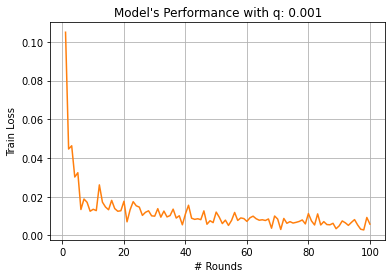

In [52]:
mnist_cnn_non_iid_trained, test_history = training(mnist_cnn,rounds, batch_size, lr,
                                                   mnist_data_train,
                                                   data_dict,
                                                   mnist_data_test,
                                                   C, K, E, q,
                                                   sampling=sampling,
                                                   tb_logger=tb_logger,
                                                   test_history=test_history,
                                                   perf_fig_file=f'{BASE_DIR}/loss.jpg'
                                                   )

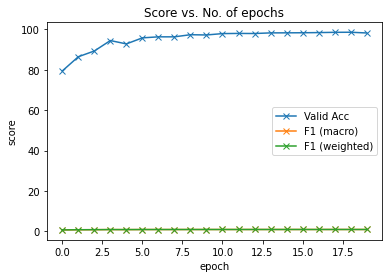

In [53]:
plot_scores(test_history, file=f'{BASE_DIR}/test_scores.jpg')

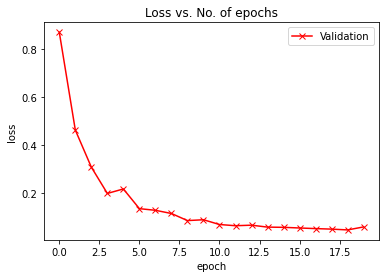

In [54]:
plot_losses(test_history, file=f'{BASE_DIR}/test_loss.jpg')

In [55]:
criterion = nn.CrossEntropyLoss()

test_scores = testing(model=mnist_cnn_non_iid_trained,
                      dataset=mnist_data_test,
                      bs=128,
                      criterion=criterion,
                      num_classes=num_classes,
                      classes=classes_test
                      )
test_scores


Test Loss: 0.057606

F1 Score: 0.981324 (macro) 0.981442 (weighted) %

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 99% (1024/1032)
Test Accuracy of     3: 98% (998/1010)
Test Accuracy of     4: 99% (979/982)
Test Accuracy of     5: 99% (884/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 97% (1005/1028)
Test Accuracy of     8: 97% (948/974)
Test Accuracy of     9: 92% (934/1009)

Final Test  Accuracy: 98.150 (9815/10000)


{'accuracy': 98.15,
 'f1_macro': 0.9813240507127073,
 'f1_weighted': 0.981441696267801,
 'loss': 0.057605904865264894}

In [56]:
tb_logger.add_hparams(hparam_dict={'rounds': rounds,
                                   'C': C,
                                   'K': K,
                                   'E': E,
                                   'batch_size': batch_size,
                                   'lr': lr,
                                   'q': q,
                                   'sampling': sampling
                                   },
                      metric_dict=test_scores,
                      run_name=exp_name)

In [57]:
tb_logger.flush()
tb_logger.close()

##### Shakespeare

In [60]:
seq_length = 80  # mcmahan17a, fedprox, qFFL
embedding_dim = 8  # mcmahan17a, fedprox, qFFL
hidden_dim = 100  # fedprox
# hidden_dim = 256  # mcmahan17a
num_classes = len(corpus)
classes = list(range(num_classes))
lstm_layers = 2  # mcmahan17a, fedprox, qFFL
dropout = 0.1  # TODO

In [61]:
data_dict, test_ds = shakespeare_noniid_partition(corpus,
                                         seq_length=seq_length, 
                                         val_split=True)

total_clients = len(data_dict.keys())
'Total users:', total_clients   #  TODO: 143 users in FedProx paper, but only 31 in qFFL. Due to randomness, it's hard to reproduce the dataset

SKIP THE_TRAGEDY_OF_KING_LEAR_MOONSHINE 40
SKIP THE_TAMING_OF_THE_SHREW_ALL_SERVANTS 25
SKIP THE_TRAGEDY_OF_KING_LEAR_DESERVING_A_FAIR_LADY 2
SKIP THE_TAMING_OF_THE_SHREW_TIMANDRA 8
SKIP PERICLES__PRINCE_OF_TYRE_SECOND_MESSENGER 58
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_THIRD_DRAWER 52
SKIP THE_TAMING_OF_THE_SHREW_BANDITTI 12
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_GENTLEMAN 44
SKIP PERICLES__PRINCE_OF_TYRE_LOVEL 40
SKIP PERICLES__PRINCE_OF_TYRE_GHOST_OF_VAUGHAN 9
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_MICHAEL 28
SKIP THE_TRAGEDY_OF_KING_LEAR_LEONARDO 3
SKIP PERICLES__PRINCE_OF_TYRE_PRIEST 12
SKIP ALL_S_WELL_THAT_ENDS_WELL_TRIBUNE 10
SKIP PERICLES__PRINCE_OF_TYRE_ALL 55
SKIP ALL_S_WELL_THAT_ENDS_WELL_CITIZENS 31
SKIP ALL_S_WELL_THAT_ENDS_WELL_FRENCHMAN 32
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_FIRST_WARDER 46
SKIP MUCH_ADO_ABOUT_NOTHING_FIRST_GENTLEMAN 16
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_DENNY 31
SKIP THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH_TOWNSMAN 6

('Total users:', 122)

In [62]:
sum([len(data_dict[u]['train_ds']) for u in data_dict])

20589

In [63]:
# number of training rounds
rounds = 5
# client fraction
C = 0.07  # fedprox (10 clients per round)
# number of clients
K = total_clients
# number of training passes on local dataset for each roung
E = 1  # qFFL
# batch size
batch_size = 10  # fedprox
# learning Rate
lr = 0.8  # fedprox, qFFL
# fairness
q = 0.001  # qFFL
# sampling
# sampling = 'uniform'
sampling = 'weighted'

In [64]:
shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=embedding_dim,  
                                   hidden_dim=hidden_dim,
                                   classes=num_classes,
                                   lstm_layers=lstm_layers,
                                   dropout=dropout,
                                   batch_first=True
                                   )

if torch.cuda.is_available():
    shakespeare_lstm.cuda()

In [65]:
BASE_DIR = '/content/gdrive/MyDrive/FedPerf/shakespeare'
exp_name = f'model_r{rounds}_c{C}_r{E}_q{q}_{sampling}'
log_dir = f'{BASE_DIR}/{exp_name}'
tb_logger = SummaryWriter(log_dir)
print(f'TBoard logger created at: {log_dir}')
exp_name

test_history = []

TBoard logger created at: /content/gdrive/MyDrive/FedPerf/shakespeare/model_r5_c0.07_r1_q0.001_weighted


Round: 1 Picking 8/122 clients: [ 8 53 23 29 99  3 73 56]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)



Round: 1... 	Average Loss: 3.747
Round: 2 Picking 8/122 clients: [ 73  76  56  50  95 114  32  12]



Round: 2... 	Average Loss: 3.311
Round: 3 Picking 8/122 clients: [119  56  73  14  81  35  65  99]



Round: 3... 	Average Loss: 3.204
Round: 4 Picking 8/122 clients: [81 12 73 93 99 82 20 95]



Round: 4... 	Average Loss: 3.194
Round: 5 Picking 8/122 clients: [ 92   3  62  56  90  39  81 119]



Round: 5... 	Average Loss: 3.153



Test Loss: 3.129225

F1 Score: 0.005561 (macro) 0.055210 (weighted) %

Test Accuracy of     0:  0% ( 0/ 3)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3: N/A (no training examples)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5: N/A (no training examples)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/163)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9: N/A (no training examples)
Test Accuracy of    10: N/A (no training examples)
Test Accuracy of    11: N/A (no training examples)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13: N/A (no training examples)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15: N/A (no training examples)
Test Accuracy of    16:  0% ( 0/156)
Test Accuracy of    17:  0% ( 0/13)
Test Accuracy of    18:  0% ( 0/ 5)
Test Accuracy of    19: N/A (no training exampl

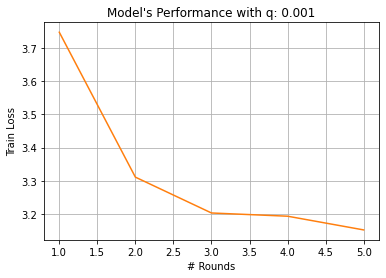

In [66]:
shakespeare_lstm_non_iid_trained, test_history = training(shakespeare_lstm,
                                            rounds, batch_size, lr,
                                            None,  # ds empty as it is included in data_dict
                                            data_dict,
                                            test_ds,
                                            C, K, E, q,
                                            sampling=sampling,
                                            tb_logger=tb_logger,
                                            test_history=test_history,
                                            perf_fig_file=f'{BASE_DIR}/loss.jpg'
                                            )

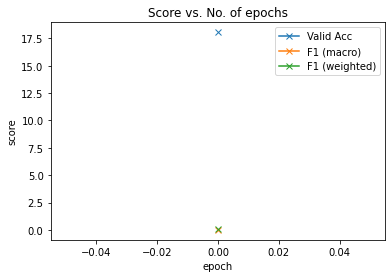

In [67]:
plot_scores(test_history, file=f'{BASE_DIR}/test_scores.jpg')

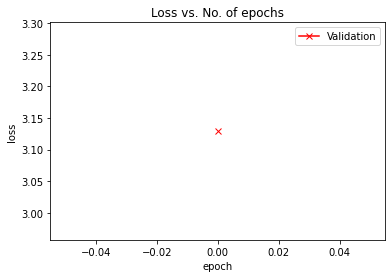

In [68]:
plot_losses(test_history, file=f'{BASE_DIR}/test_loss.jpg')

In [74]:
criterion = nn.CrossEntropyLoss()

test_scores = testing(model=shakespeare_lstm_non_iid_trained,
                      dataset=test_ds,
                      bs=batch_size,
                      criterion=criterion,
                      num_classes=num_classes,
                      classes=classes
                      )
test_scores


Test Loss: 3.129225

F1 Score: 0.005561 (macro) 0.055210 (weighted) %

Test Accuracy of     0:  0% ( 0/ 3)
Test Accuracy of     1: N/A (no training examples)
Test Accuracy of     2: N/A (no training examples)
Test Accuracy of     3: N/A (no training examples)
Test Accuracy of     4: N/A (no training examples)
Test Accuracy of     5: N/A (no training examples)
Test Accuracy of     6:  0% ( 0/ 2)
Test Accuracy of     7:  0% ( 0/163)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9: N/A (no training examples)
Test Accuracy of    10: N/A (no training examples)
Test Accuracy of    11: N/A (no training examples)
Test Accuracy of    12: N/A (no training examples)
Test Accuracy of    13: N/A (no training examples)
Test Accuracy of    14: N/A (no training examples)
Test Accuracy of    15: N/A (no training examples)
Test Accuracy of    16:  0% ( 0/156)
Test Accuracy of    17:  0% ( 0/13)
Test Accuracy of    18:  0% ( 0/ 5)
Test Accuracy of    19: N/A (no training exampl

{'accuracy': 0.18052256532066507,
 'f1_macro': 0.00556063654655204,
 'f1_weighted': 0.05521012058096799,
 'loss': 3.129225188366308}

In [71]:
tb_logger.add_hparams(hparam_dict={'rounds': rounds,
                                   'C': C,
                                   'K': K,
                                   'E': E,
                                   'batch_size': batch_size,
                                   'lr': lr,
                                   'q': q,
                                   'sampling': sampling
                                   },
                      metric_dict=test_scores,
                      run_name=exp_name)

In [72]:
tb_logger.flush()
tb_logger.close()